# Wasserstein GAN

##### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from time import time
import os
os.chdir('C:/Users/Nicolas/Documents/Data/Faces')
import argparse
import math
import sys
import re
import itertools
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import torchvision.transforms as transforms
from torchvision.utils import save_image

##### Loading all file names

In [2]:
files = glob('combined/*.jpg')
files = np.random.permutation(files)

In [3]:
files[:5]

array(['combined\\24_0_2_20170116161813837.jpg.chip.jpg',
       'combined\\37_0_3_20170119180031371.jpg.chip.jpg',
       'combined\\2_1_2_20161219154604597.jpg.chip.jpg',
       'combined\\42_1_2_20170104204657182.jpg.chip.jpg',
       'combined\\41_0_0_20170117133125264.jpg.chip.jpg'], dtype='<U47')

##### Keeping all correctly formatted labels

In [4]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Removing problematic target names

In [5]:
# faces = [i for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d'))  == 2 ]

In [6]:
faces = [i for i in files if (i[-34] == '0') and len(i[-37:-35].strip('\\').strip('d'))  == 2 ] # MEN

In [7]:
# y = [i[-34] for i in files if (i[-34] in ('0', '1')) and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [8]:
y = [i[-34] for i in files if (i[-34] == '0') and len(i[-37:-35].strip('\\').strip('d')) > 1 ] # MEN

In [9]:
sex = ['men', 'women']

In [10]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### This is the shape width/height

In [11]:
dim = 60

#### Cropping function

In [12]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [13]:
print('Scaling...', end='')
start = time()
x = []
num_to_load = len(faces) # int(len(faces)/5) 
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'\rDone. {int(time() - start)} seconds')
y = y[:num_to_load]

Done. 7 seconds


##### Turning the pictures into arrays

In [14]:
x = np.array(x, dtype=np.float32).reshape(-1, 1, 60, 60)
y = np.array(y, dtype=np.float32)
labels = y.copy()

##### Turning the targets into a 2D matrix

In [15]:
assert x.ndim == 4, 'The input is the wrong shape!'

In [16]:
yy, xx = y.nbytes, x.nbytes

In [17]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 157,536,000 bytes and the size of Y is 43,760 bytes.


In [18]:
files, faces = None, None

##### Displaying the pictures

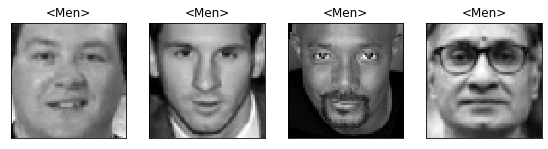

In [19]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(0, x.shape[0])
    ax = plt.imshow(x[rand][0, :, :], cmap='gray')
    plt.title('<{}>'.format(sex[int(labels[rand])].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

In [20]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
# x, y = None, None

In [21]:
print('Scaling...', end='')
image_size = x.shape[1] * x.shape[1] 
x = x.astype('float32') / 255 
print('\rDone.     ')

Done.     


In [22]:
if torch.cuda.is_available():
    x = torch.from_numpy(x) 
    y = torch.from_numpy(y)
    print('Tensors successfully flushed to CUDA.')
else:
    print('CUDA not available!')

Tensors successfully flushed to CUDA.


##### Making a dataset class

In [23]:
class Face():
    
    def __init__(self):
        self.len = x.shape[0]
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return x[index], y[index].unsqueeze(0)
    
    def __len__(self):
        return self.len

##### Instantiating the class

In [24]:
faces = Face()

##### Parsing the args

In [25]:
os.makedirs("images_wsgan", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=32, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.005, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=50, help="interval betwen image samples")
opt, unknown = parser.parse_known_args()
print(opt)

Namespace(batch_size=128, channels=1, clip_value=0.005, img_size=60, latent_dim=32, lr=5e-05, n_cpu=8, n_critic=5, n_epochs=50, sample_interval=50)


In [26]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [28]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [29]:
# Configure data loader
dataloader = torch.utils.data.DataLoader(faces,
    batch_size=opt.batch_size,
    shuffle=True,
)

In [30]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        # Train the generator every n_critic iterations
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

#             print(
#                 "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                 % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
#             )

        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images_wsgan/%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1

In [ ]:
# parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
# parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=16, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=60, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
# parser.add_argument("--clip_value", type=float, default=0.005, help="lower and upper clip value for disc. weights")
# parser.add_argument("--sample_interval", type=int, default=50, help="interval betwen image samples")

# [Epoch 49/50] [Batch 160/162] [D loss: -0.059785] [G loss: -0.016357]

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

In [ ]:
images = []
for file_name in sorted_alphanumeric(glob('images_wsgan/*.png')):
    if file_name.endswith('.png'):
        file_path = os.path.join(file_name)
        images.append(file_path)

In [ ]:
picture = plt.imread(images[-1])
plt.figure(figsize=(6, 6))
plt.imshow(picture)
plt.xticks([]), plt.yticks([])
plt.title('Generated Faces')
plt.show()